## For making images shown in figure 5

In [1]:
%load_ext autoreload
%autoreload 2

# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *


/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(1,), but only accepts 1 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


## Show the concept of signal space

  0%|          | 0/4 [00:00<?, ?it/s]

initial loss 0.562765676422678


 25%|██▌       | 1/4 [01:50<05:32, 110.80s/it]

initial loss 0.5895030440496647


 50%|█████     | 2/4 [02:37<02:26, 73.05s/it] 

initial loss 0.20781870214291803


 75%|███████▌  | 3/4 [02:54<00:47, 47.39s/it]

initial loss 0.07613436023617134


100%|██████████| 4/4 [03:22<00:00, 50.63s/it]

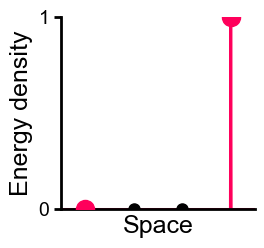

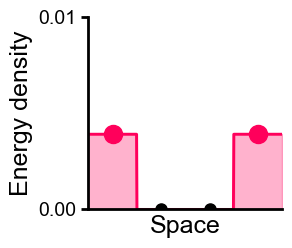

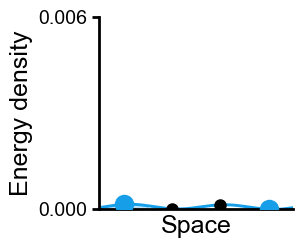

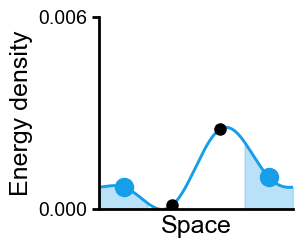

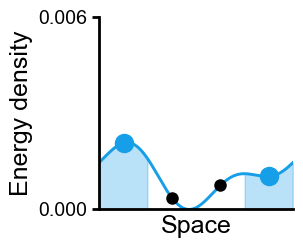

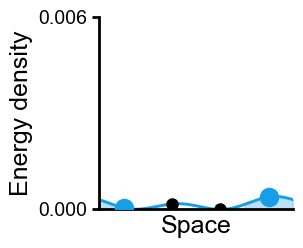

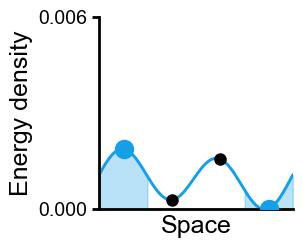

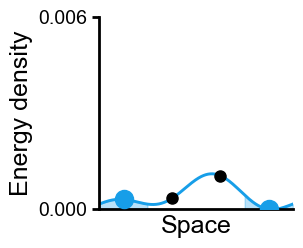

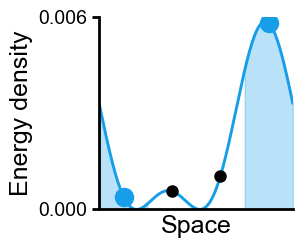

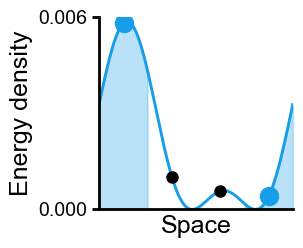

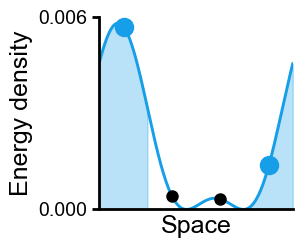

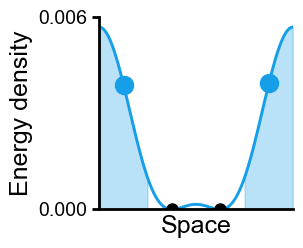

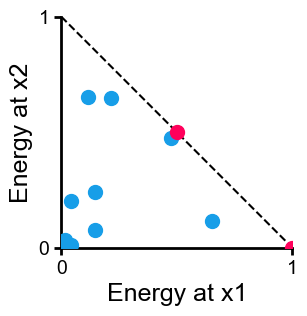

In [2]:
# delta function
num_nyquist_samples = 4
sampling_indices = (3, 0)

delta = onp.zeros(UPSAMPLED_SIGNAL_LENGTH)
integration_interval_size = UPSAMPLED_SIGNAL_LENGTH // num_nyquist_samples
delta[int(integration_interval_size * (sampling_indices[0] + 0.5))] = 1

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), sharex=True, sharey=True)
plot_in_spatial_coordinates(ax, delta, sampling_indices=sampling_indices, color=get_color_cycle()[2], show_samples=True,
                            show_integration=True, num_nyquist_samples=num_nyquist_samples)
ax.set(xlabel='Space', ylim=[0, 1], yticks=[0, 1], yticklabels=['0', '1'])

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'signal_space_single_delta' + '.pdf', transparent=True)



# rect function

rect = onp.zeros(UPSAMPLED_SIGNAL_LENGTH)
integration_interval_size = UPSAMPLED_SIGNAL_LENGTH // num_nyquist_samples
rect[integration_interval_size * sampling_indices[0]:integration_interval_size * (sampling_indices[0] + 1)] = 1
rect[integration_interval_size * sampling_indices[1]:integration_interval_size * (sampling_indices[1] + 1)] = 1
rect /= np.sum(rect)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), sharex=True, sharey=True)
plot_in_spatial_coordinates(ax, rect, sampling_indices=sampling_indices, color=get_color_cycle()[2], show_samples=True,
                            show_integration=True, num_nyquist_samples=num_nyquist_samples)
ax.set(xlabel='Space', ylim=[0, .01], yticks=[0, .01])

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'signal_space_rect' + '.pdf', transparent=True)



# some random signals
random_valid_signals = [generate_random_signal(num_nyquist_samples=num_nyquist_samples, unit_energy=False) for i in range(6)]

for i, signal in enumerate(random_valid_signals):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), sharex=True, sharey=True)
    plot_in_spatial_coordinates(ax, signal, sampling_indices=sampling_indices, color=get_color_cycle()[0], show_samples=True,
                                show_integration=True, num_nyquist_samples=num_nyquist_samples)
    ax.set(xlabel='Space', ylim=[0, .006], yticks=[0, .006])

    fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'signal_space_random_{i}' + '.pdf', transparent=True)


# optimize some signals close to the boundaries
    
target_integrated_signals = onp.zeros((4, num_nyquist_samples))
target_integrated_signals[0, sampling_indices[0]] = 1
target_integrated_signals[1, sampling_indices[1]] = 1
target_integrated_signals[2, sampling_indices[0]] = 0.25
target_integrated_signals[2, sampling_indices[1]] = 0.75
target_integrated_signals[3, sampling_indices[0]] = 0.5
target_integrated_signals[3, sampling_indices[1]] = 0.5

_, optimized_signals = optimize_towards_target_signals(target_integrated_signals, generate_random_object('delta'), 
                                generate_random_signal(num_nyquist_samples=num_nyquist_samples), 
                                sampling_indices=sampling_indices, verbose=True)

for i, signal in enumerate(optimized_signals):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), sharex=True, sharey=True)
    plot_in_spatial_coordinates(ax, signal, sampling_indices=sampling_indices, color=get_color_cycle()[0], show_samples=True,
                                show_integration=True, num_nyquist_samples=num_nyquist_samples)
    ax.set(xlabel='Space', ylim=[0, .006], yticks=[0, .006])

    fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'signal_space_optimized_{i}' + '.pdf', transparent=True)



# plot them all in intensity coordinates
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
s = 100
for i, signal in enumerate(random_valid_signals):
    plot_in_intensity_coordinates(ax, signal, sampling_indices=sampling_indices, color=get_color_cycle()[0], num_nyquist_samples=num_nyquist_samples, s=s)

for i, signal in enumerate(optimized_signals):
    plot_in_intensity_coordinates(ax, signal, sampling_indices=sampling_indices, color=get_color_cycle()[0], num_nyquist_samples=num_nyquist_samples, s=s)

plot_in_intensity_coordinates(ax, delta, sampling_indices=sampling_indices, color=get_color_cycle()[2], 
                              num_nyquist_samples=num_nyquist_samples, s=s)
plot_in_intensity_coordinates(ax, rect, sampling_indices=sampling_indices, color=get_color_cycle()[2], 
                              num_nyquist_samples=num_nyquist_samples, s=s)

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'signal_space_intensity_coords' + '.pdf', transparent=True)

# Introduce the convolutional model

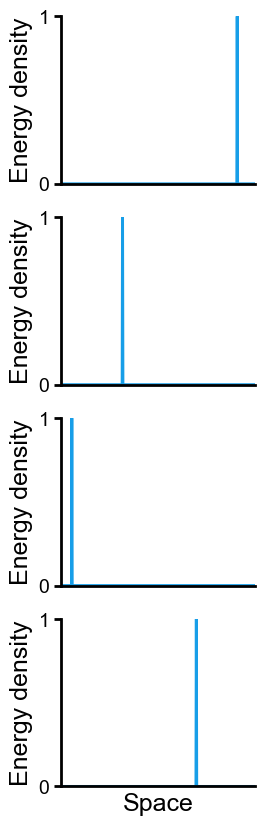

In [13]:
n_objects = 4
objects = np.array([generate_random_object('delta') for i in range(n_objects)])
# plot all the objects
fig, ax = plt.subplots(n_objects, 1, figsize=(2.5, 2.5*n_objects), sharex=True, sharey=True)
for a, obj in zip(ax, objects):
    # fudge position so it matches better with the output signals below
    # obj = np.roll(obj, 16)

    plot_in_spatial_coordinates(a, obj)
    a.set_xlabel(None)
ax[-1].set(xlabel='Space', ylim=[0, 1], yticks=[0, 1], yticklabels=['0', '1'])

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'example_delta_objcts' + '.pdf', transparent=True)


In [4]:
# run a quick optimization to get a sinc-like psf

N_objects = 2000
noise_sigma = 0.01
num_nyquist_samples = 8

objects_fn = lambda : np.array([generate_random_object('delta') for i in range(N_objects)])
initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, max_epochs=1000)

initial loss 0.01007248874572888


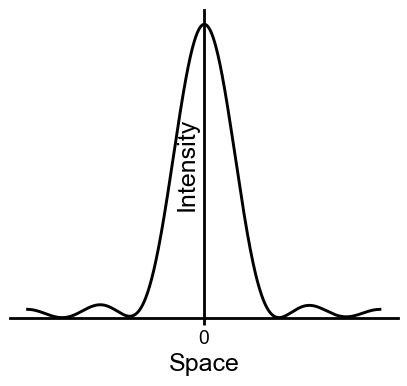

In [15]:
# signal = generate_random_1_over_f_signal(num_non_dc_in_bandlimit= 10)
delta_function = onp.zeros(UPSAMPLED_SIGNAL_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

kernel = signal_from_params(optimized_params)
# rotate the kernel so that it's centered
kernel = np.roll(kernel, kernel.size // 2 - np.argmax(kernel))
kernel = np.fft.fftshift(kernel)
conv_mat = make_convolutional_encoder(kernel)

# do the convolution
output_signal = conv_mat @ input_signal
# plot the output signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
#  plot_lim= np.ceil(10 * np.max(kernel)) / 10
ax.plot(np.arange(-output_signal.size // 2, output_signal.size // 2), output_signal, color='k', linewidth=2.1)
clear_spines(ax)
ax.set(ylim=[0, None], xlabel='Space', ylabel='Intensity', xticks=[0], yticks=[])
ax.spines['left'].set_position('zero')

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'example_psf' + '.pdf', transparent=True)


## Convolve objects with PSF to get output signals

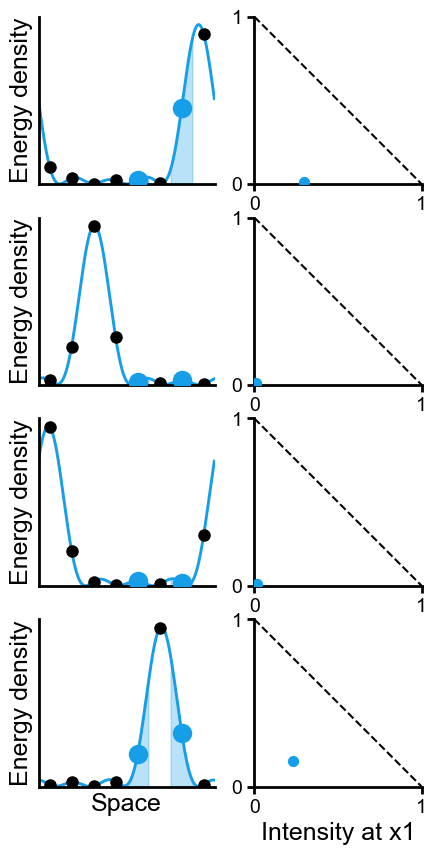

In [26]:
sampling_indices = (6, 4)

# convolve the objects
params = params_from_signal(kernel)
output_signals = conv_forward_model(params, objects, align_center=False, num_nyquist_samples=num_nyquist_samples)

fig, ax = plt.subplots(n_objects, 2, figsize=(5, 2.5*n_objects), sharex=False, sharey=False)

for a, sig in zip(ax, output_signals):
    plot_in_spatial_coordinates(a[0], sig, sampling_indices=sampling_indices, show_integration=True,
                                show_samples=True, num_nyquist_samples=num_nyquist_samples)
    a[0].set(xlabel=None, xticklabels=[])

    plot_in_intensity_coordinates(a[1], sig, sampling_indices=sampling_indices)
    a[1].set(ylabel=None, )

ax[-1, 0].set_xlabel('Space')
ax[-1, 1].set_xlabel('Intensity at x1')

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'example_output_signals' + '.pdf', transparent=True)
